In [29]:
import os
import transformers
import pandas as pd
import numpy as np
import torch
from torch.optim import Adam
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from tqdm import tqdm


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')
ext_df = pd.read_csv('/kaggle/input/argugpt/argugpt.csv')[['id','text','model']]
ext_df.rename(columns={'model':'source'}, inplace=True)
ext_df['label'] = 1

In [5]:
ext_df = pd.concat([
    df[df.source=='persuade_corpus'].sample(8000),
    df[df.source!='persuade_corpus'],
    ext_df,
])


In [7]:
data = ext_df
data.label.value_counts()

label
1    18452
0    11796
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your dataset and 'labels' are corresponding labels/targets

# Split the data into training and temporary sets (80% training, 20% temporary)
train_set, temp_data, train_labels, temp_labels = train_test_split(data, data.label, test_size=0.3, stratify=data.label, random_state=42)

# Split the temporary data into testing and validation sets (50% testing, 50% validation of the remaining data)
test_set, val_set, test_labels, val_labels = train_test_split(temp_data, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


In [13]:
def preprocess_function_tf(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Lowercase the text
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [14]:
pptrain = train_set.text.apply(preprocess_function_tf)
pptest = test_set.text.apply(preprocess_function_tf)
ppval = val_set.text.apply(preprocess_function_tf)

In [15]:

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True,max_features=6000,  min_df=5, norm='l2', encoding='utf-8', decode_error='ignore')
# Fit and transform the preprocessed text
tfidf_matrix_train = tfidf_vectorizer.fit_transform(pptrain)
tfidf_matrix_val = tfidf_vectorizer.transform(ppval)
tfidf_matrix_test = tfidf_vectorizer.transform(pptest)

# Now 'tfidf_matrix' contains the TF-IDF representation of your preprocessed text

In [16]:
# # Load model directly
# model = AutoModel.from_pretrained("microsoft/deberta-v3-xsmall", output_attentions = True)

In [24]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-xsmall", use_fast=True)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [18]:
def preprocess_function(examples):
    return tokenizer(examples, max_length=128, padding='max_length', truncation=True)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [19]:
# ins = preprocess_function(train_set.text[0])

In [20]:
# # Assuming you have a single example from ds_train_input_only
# model.to("cuda")
# # Forward pass through the model

# # Extract relevant features
# input_ids = torch.tensor(ins['input_ids'], dtype=torch.long).unsqueeze(0).to("cuda")
# token_type_ids = torch.tensor(ins['token_type_ids'], dtype=torch.long).unsqueeze(0).to("cuda")
# attention_mask = torch.tensor(ins['attention_mask'], dtype=torch.long).unsqueeze(0).to("cuda")
# with torch.no_grad():
#     outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)


In [21]:
import torch
import torch.nn as nn
from transformers import DebertaModel, DebertaTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

class DeBERTaBinaryClassifier(nn.Module):
    def __init__(self, deberta_model_name, num_classes, tfidf_output_size=5000):
        super(DeBERTaBinaryClassifier, self).__init__()

        # Load pre-trained DeBERTa model and tokenizer
        self.deberta = DebertaModel.from_pretrained(deberta_model_name, ignore_mismatched_sizes=True, output_attentions=True)
        self.tokenizer = AutoTokenizer.from_pretrained(deberta_model_name)  

        # Modify the classifier head for binary classification
        deberta_hidden_size = self.deberta.config.hidden_size
        self.deberta_classifier = nn.Linear(deberta_hidden_size,256 )

        self.tfidf_classifier = nn.Linear(tfidf_output_size, 128)

        # Combine DeBERTa and TF-IDF with a larger linear layer
        self.combined_classifier = nn.Linear(128 + 256, num_classes)

    def forward(self, input_ids, input_type, input_attension, tfidf_input):
        # DeBERTa forward pass         
        deberta_outputs = self.deberta(input_ids= input_ids, token_type_ids=input_type, attention_mask=input_attension)
        deberta_cls_embedding = deberta_outputs.last_hidden_state[:, 0, :]
        deberta_logits = self.deberta_classifier(deberta_cls_embedding)
        attentions = deberta_outputs['attentions']
        # TF-IDF forward pass
        tfidf_logits = self.tfidf_classifier(tfidf_input)
        # print("DeBERTa logits shape:", deberta_logits.shape)
        # print("TF-IDF logits shape:", tfidf_logits.shape)
        # Concatenate DeBERTa and TF-IDF embeddings
        combined_embedding = torch.cat((deberta_logits, tfidf_logits), dim=1)

        # Combined forward pass
        combined_logits = self.combined_classifier(combined_embedding)

        return  combined_logits, attentions


In [22]:
model = DeBERTaBinaryClassifier("microsoft/deberta-v3-base",2,6000)

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

You are using a model of type deberta-v2 to instantiate a model of type deberta. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaModel were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['deberta.encoder.layer.5.attention.self.v_bias', 'deberta.encoder.layer.0.attention.self.in_proj.weight', 'deberta.encoder.layer.8.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.2.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.11.attention.self.v_bias', 'deberta.encoder.layer.4.attention.self.in_proj.weight', 'deberta.encoder.layer.6.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.7.attention.self.in_proj.weight', 'deberta.encoder.layer.0.attention.self.pos_proj.weight', 'deberta.encoder.layer.9.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.1.attention.self.in_proj.weight', 'deberta.encoder.layer.1.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.4.attention.self.v_bias', 'deberta.encoder.layer.6.attention.self.q_bias', 'deberta.encoder.layer.9.attention.self.in_proj.weight', 'deberta.encoder.layer.0.attent

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [25]:
train_enc = train_set.text.apply(preprocess_function)
val_enc = val_set.text.apply(preprocess_function)
test_enc = test_set.text.apply(preprocess_function)

In [28]:

tfidf_matrix_train_t = torch.tensor(tfidf_matrix_train.toarray(), dtype=torch.float32)
tfidf_matrix_val_t = torch.tensor(tfidf_matrix_val.toarray(), dtype=torch.float32)
tfidf_matrix_test_t = torch.tensor(tfidf_matrix_test.toarray(), dtype=torch.float32)

# Convert them to torch tensors
deberta_input_train = [{'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
                       'token_type_ids': torch.tensor(item['token_type_ids'], dtype=torch.long),
                       'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long)} for item in train_enc]

deberta_input_val = [{'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
                     'token_type_ids': torch.tensor(item['token_type_ids'], dtype=torch.long),
                     'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long)} for item in val_enc]

deberta_input_test = [{'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
                      'token_type_ids': torch.tensor(item['token_type_ids'], dtype=torch.long),
                      'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long)} for item in test_enc]

# Convert lists to tensors
deberta_input_train_tensors = {
    'input_ids': torch.stack([item['input_ids'] for item in deberta_input_train]),
    'token_type_ids': torch.stack([item['token_type_ids'] for item in deberta_input_train]),
    'attention_mask': torch.stack([item['attention_mask'] for item in deberta_input_train])
}

deberta_input_val_tensors = {
    'input_ids': torch.stack([item['input_ids'] for item in deberta_input_val]),
    'token_type_ids': torch.stack([item['token_type_ids'] for item in deberta_input_val]),
    'attention_mask': torch.stack([item['attention_mask'] for item in deberta_input_val])
}

deberta_input_test_tensors = {
    'input_ids': torch.stack([item['input_ids'] for item in deberta_input_test]),
    'token_type_ids': torch.stack([item['token_type_ids'] for item in deberta_input_test]),
    'attention_mask': torch.stack([item['attention_mask'] for item in deberta_input_test])
}

# Convert labels to tensors
train_labels_t = torch.tensor(train_labels.values)
val_labels_t = torch.tensor(val_labels.values)
test_labels_t = torch.tensor(test_labels.values)

# Create TensorDatasets with both DeBERTa input and TF-IDF input
train_dataset = TensorDataset(deberta_input_train_tensors['input_ids'], 
                              deberta_input_train_tensors['token_type_ids'],
                              deberta_input_train_tensors['attention_mask'],
                              tfidf_matrix_train_t, 
                              train_labels_t)
val_dataset = TensorDataset(deberta_input_val_tensors['input_ids'], 
                            deberta_input_val_tensors['token_type_ids'],
                            deberta_input_val_tensors['attention_mask'],
                            tfidf_matrix_val_t, 
                            val_labels_t)
test_dataset = TensorDataset(deberta_input_test_tensors['input_ids'], 
                             deberta_input_test_tensors['token_type_ids'],
                             deberta_input_test_tensors['attention_mask'],
                             tfidf_matrix_test_t, 
                             test_labels_t)

# Create DataLoader without custom collate function
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [30]:

train_losses = []
val_accs = []
auc_scores = []

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # Use tqdm for a progress bar
    with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False) as tqdm_loader:
        for input_ids, input_type, input_att, tfidf_inputs, labels in tqdm_loader:
            input_ids = input_ids.to(device)
            input_type = input_type.to(device)
            input_att = input_att.to(device)
            tfidf_inputs, labels = tfidf_inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            combined_outputs, _ = model(input_ids, input_type, input_att, tfidf_input=tfidf_inputs)
            loss = criterion(combined_outputs, labels)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Update the progress bar description with the current loss
            tqdm_loader.set_postfix({'Training Loss': loss.item()})
    

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    all_probabilities = []
    with torch.no_grad():
        for input_ids, input_type, input_att, tfidf_inputs, labels in val_loader:
            input_ids = input_ids.to(device)
            input_type = input_type.to(device)
            input_att = input_att.to(device)
            
            tfidf_inputs, labels = tfidf_inputs.to(device), labels.to(device)

            # Forward pass
            combined_outputs, _ = model(input_ids, input_type, input_att, tfidf_input=tfidf_inputs)
            prob, predicted = torch.max(combined_outputs, 1)
            all_probabilities.extend(prob.cpu())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)
    auc_score = roc_auc_score(val_set.label, all_probabilities)
    auc_scores.append(auc_score)
    accuracy = correct / total
    val_accs.append(accuracy)
    print(f"Epoch {epoch + 1}, Training Loss: {average_loss}")
    print(f"Validation Accuracy: {accuracy}")
    print(f"Validation AUC Score: {auc_score}")

Epoch 1, Training Loss: 0.266719365869494
Validation Accuracy: 0.9508594094314676
Validation AUC Score: 0.5424163564220633


Epoch 2, Training Loss: 0.10736946824634183
Validation Accuracy: 0.9638607315998237
Validation AUC Score: 0.6040448140165247


Epoch 3, Training Loss: 0.08744172371777613
Validation Accuracy: 0.9510797708241516
Validation AUC Score: 0.9083969130661964


Epoch 4, Training Loss: 0.06566111254998204
Validation Accuracy: 0.9717937417364477
Validation AUC Score: 0.810260319715228


Epoch 5, Training Loss: 0.05242513740763034
Validation Accuracy: 0.9592331423534597
Validation AUC Score: 0.7156461252081904


Epoch 6, Training Loss: 0.04058357066540976
Validation Accuracy: 0.9744380784486558
Validation AUC Score: 0.7877153342477385


Epoch 7, Training Loss: 0.03414638787634626
Validation Accuracy: 0.9755398854120758
Validation AUC Score: 0.9240457937363248


Epoch 8, Training Loss: 0.03066790270067968
Validation Accuracy: 0.9781842221242838
Validation AUC Score: 0.8299361549263576


Epoch 9, Training Loss: 0.024037309130495472
Validation Accuracy: 0.9722344645218158
Validation AUC Score: 0.6576158926880246


Epoch 10, Training Loss: 0.019381647051114722
Validation Accuracy: 0.9750991626267078
Validation AUC Score: 0.8698474902844453


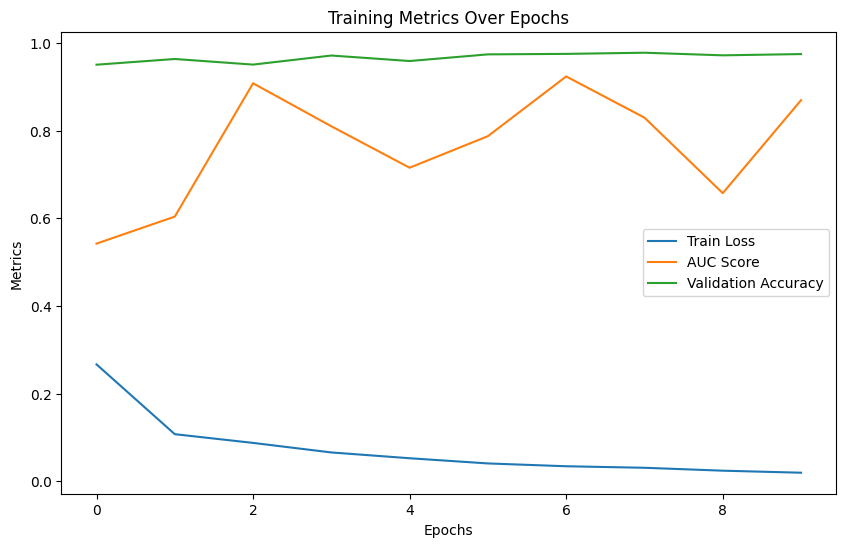

In [46]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting training losses
plt.plot(train_losses, label='Train Loss')

# Plotting AUC scores
plt.plot(auc_scores, label='AUC Score')

# Plotting validation accuracies
plt.plot(val_accs, label='Validation Accuracy')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Metrics Over Epochs')
plt.legend()

# Show the plot
plt.show()

In [33]:
# Validation loop
model.eval()
correct = 0
total = 0
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for input_ids, input_type, input_att, tfidf_inputs, labels in test_loader:
        input_ids = input_ids.to(device)
        input_type = input_type.to(device)
        input_att = input_att.to(device)
        
        tfidf_inputs, labels = tfidf_inputs.to(device), labels.to(device)

        # Forward pass
        combined_outputs, _ = model(input_ids, input_type, input_att, tfidf_input=tfidf_inputs)
        prob, predicted = torch.max(combined_outputs, 1)
        all_predictions.extend(predicted.cpu())
        all_probabilities.extend(prob.cpu())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
auc_score = roc_auc_score(test_set.label, all_probabilities)    
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")
print(f"Test AUC Score: {auc_score}")

Test Accuracy: 0.9748732642715451
Test AUC Score: 0.8725409427618229


In [29]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in the model: {total_params}")


Number of parameters in the model: 199344770


In [34]:
from sklearn.metrics import classification_report
# Evaluate the accuracy
print(classification_report(test_set.label, all_predictions))


              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1769
           1       0.99      0.97      0.98      2768

    accuracy                           0.97      4537
   macro avg       0.97      0.98      0.97      4537
weighted avg       0.98      0.97      0.97      4537



0.8725409427618229


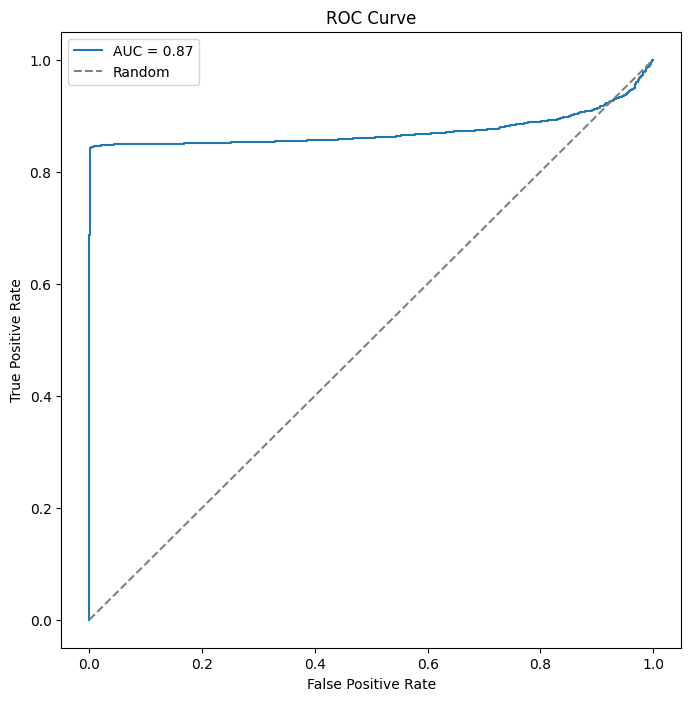

In [35]:

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_set.label,all_probabilities)

# Calculate the AUC-ROC score
auc_score = roc_auc_score(test_set.label, all_probabilities)
print(auc_score)
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [47]:
def predict(text):
    tfidf_input = tfidf_vectorizer.transform(text)
    tfidf_input = torch.Tensor(tfidf_input.toarray()).to(device)
    # print(tfidf_input.shape)
    ins = preprocess_function(text)
    input_ids = torch.tensor(ins['input_ids']).to(device)
    input_type = torch.tensor(ins['token_type_ids']).to(device)
    input_att = torch.tensor(ins['attention_mask']).to(device)
    with torch.no_grad():
        outputs = model(input_ids, input_type, input_att, tfidf_input=tfidf_input)
    return ins, outputs[0], outputs[1]

In [48]:
def normalize_attention(attention_weights):
    min_val = np.min(attention_weights)
    max_val = np.max(attention_weights)
    normalized_attention = (attention_weights - min_val) / (max_val- min_val)
    return normalized_attention

def attention_explain(attentions, input_data):
    layer_num = 11
    average_attention_weights = np.min(attentions[layer_num].cpu().detach().numpy(), axis=1)
    input_attention = np.max(average_attention_weights, axis=1).reshape(len(input_data.tokens()),)
    normalized_input_attention = normalize_attention(input_attention)

    # Tokenize the main string using the provided tokenizer
    tokens = input_data['input_ids'][0]

    # Initialize variables to store cumulative attention and matched words
    cumulative_attention = 0.0
    matched_sentences = []
    current_sentence = []

    # Iterate over tokens and accumulate attention for corresponding words in the main string
    for token, attention in zip(tokens, normalized_input_attention):
        word = tokenizer.decode([token])
        # if word == '[PAD]':
        #     continue
        # Check if the current word is a sentence separator or period
        if word in ['.', '[SEP]']:
            if current_sentence:
                cumulative_attention += attention
                matched_sentences.append((' '.join(current_sentence), cumulative_attention))
                current_sentence = []
        elif word != '[CLS]':  # Skip [CLS] token

            # Add the word to the current sentence
            current_sentence.append(word)

    # Include the attention of [SEP] to the sentence that follows it
    for i in range(1, len(matched_sentences)):
        _, prev_cum_att = matched_sentences[i - 1]
        sentence, cum_att = matched_sentences[i]
        if '[SEP]' in sentence:
            cum_att += prev_cum_att
            matched_sentences[i] = (sentence, cum_att)
    
    # Print matched sentences and their cumulative attention after sorting
    sorted_sentences = sorted(matched_sentences, key=lambda x: x[1], reverse=True)

    for sentence, cum_att in sorted_sentences:
        print(f"{sentence}: {cum_att:.6f}")

    return sorted_sentences

In [84]:
text_human = ['''
The New York Times is a national daily newspaper based in New York City. A newspaper of record, it is the second-largest newspaper by circulation and one of the longest-running newspapers in the United States.
''']

In [85]:
input_data, result, attentions = predict(text_human)

In [86]:
result 

tensor([[ 2.5548, -2.4132]], device='cuda:0')

In [87]:
attention_explain(attentions, input_data)

A newspaper of record , it is the second - largest newspaper by circulation and one of the longest - running newspapers in the United States: 1.565952
The New York Times is a national daily newspaper based in New York City: 0.782702


[('A newspaper of record , it is the second - largest newspaper by circulation and one of the longest - running newspapers in the United States',
  1.5659524202346802),
 ('The New York Times is a national daily newspaper based in New York City',
  0.7827022075653076)]

In [93]:
text_GPT = ['''
Based in New York City, The New York Times is a national daily newspaper renowned as a newspaper of record. It holds the position of the second-largest newspaper by circulation and stands as one of the longest-running newspapers in the United States.
''']

In [94]:
input_data, result, attentions = predict(text_GPT)

In [95]:
result

tensor([[-2.2026,  2.0225]], device='cuda:0')

In [91]:
attention_explain(attentions, input_data)

It holds the position of the second - largest newspaper by circulation and stands as one of the longest - running newspapers in the United States: 1.609411
Based in New York City , The New York Times is a national daily newspaper renowned as a newspaper of record: 0.804392


[('It holds the position of the second - largest newspaper by circulation and stands as one of the longest - running newspapers in the United States',
  1.6094108819961548),
 ('Based in New York City , The New York Times is a national daily newspaper renowned as a newspaper of record',
  0.8043922185897827)]

In [99]:
text_short = ['''
This is a short text to see which words the model attends to, to check if the text is AI Generated or not.
''']
input_data, result, attentions = predict(text_short)
result

tensor([[ 1.9537, -1.8311]], device='cuda:0')

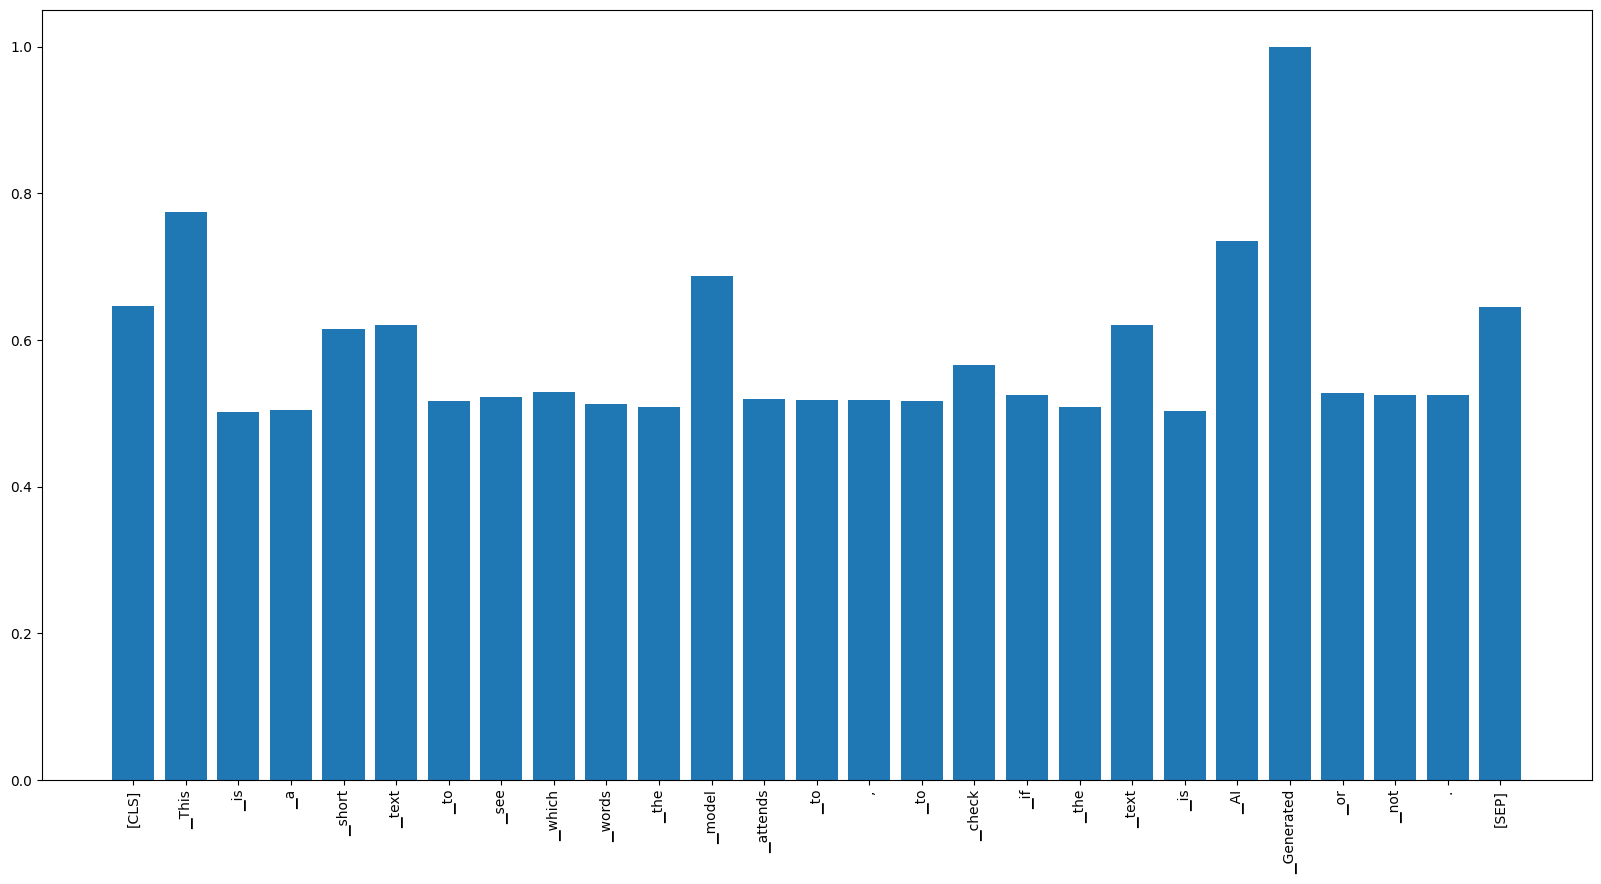

In [100]:
layer_num = 11
#average_attention_weights = torch.mean(attentions[layer_num], dim=1).cpu().squeeze(0).detach().numpy()
average_attention_weights = np.max(attentions[layer_num].cpu().detach().numpy(), axis=1)
#input_attention = np.mean(average_attention_weights,axis=0).reshape(len(input_data.tokens()),)
input_attention = np.max(average_attention_weights,axis=1).reshape(len(input_data.tokens()),)

def visualize_attention(input_data, attention_weights):
    tokens = input_data.tokens()
    
    # Filter out [PAD] tokens and corresponding attention weights
    non_pad_tokens = [token for token in tokens if token != '[PAD]']
    non_pad_attention_weights = attention_weights[:len(non_pad_tokens)]
    
    plt.figure(figsize=(20, 10))
    plt.bar(range(len(non_pad_tokens)), non_pad_attention_weights)
    plt.xticks(range(len(non_pad_tokens)), non_pad_tokens, rotation='vertical')
    plt.show()

# Example usage
normalized_input_attention = normalize_attention(input_attention)
visualize_attention(input_data, normalized_input_attention)


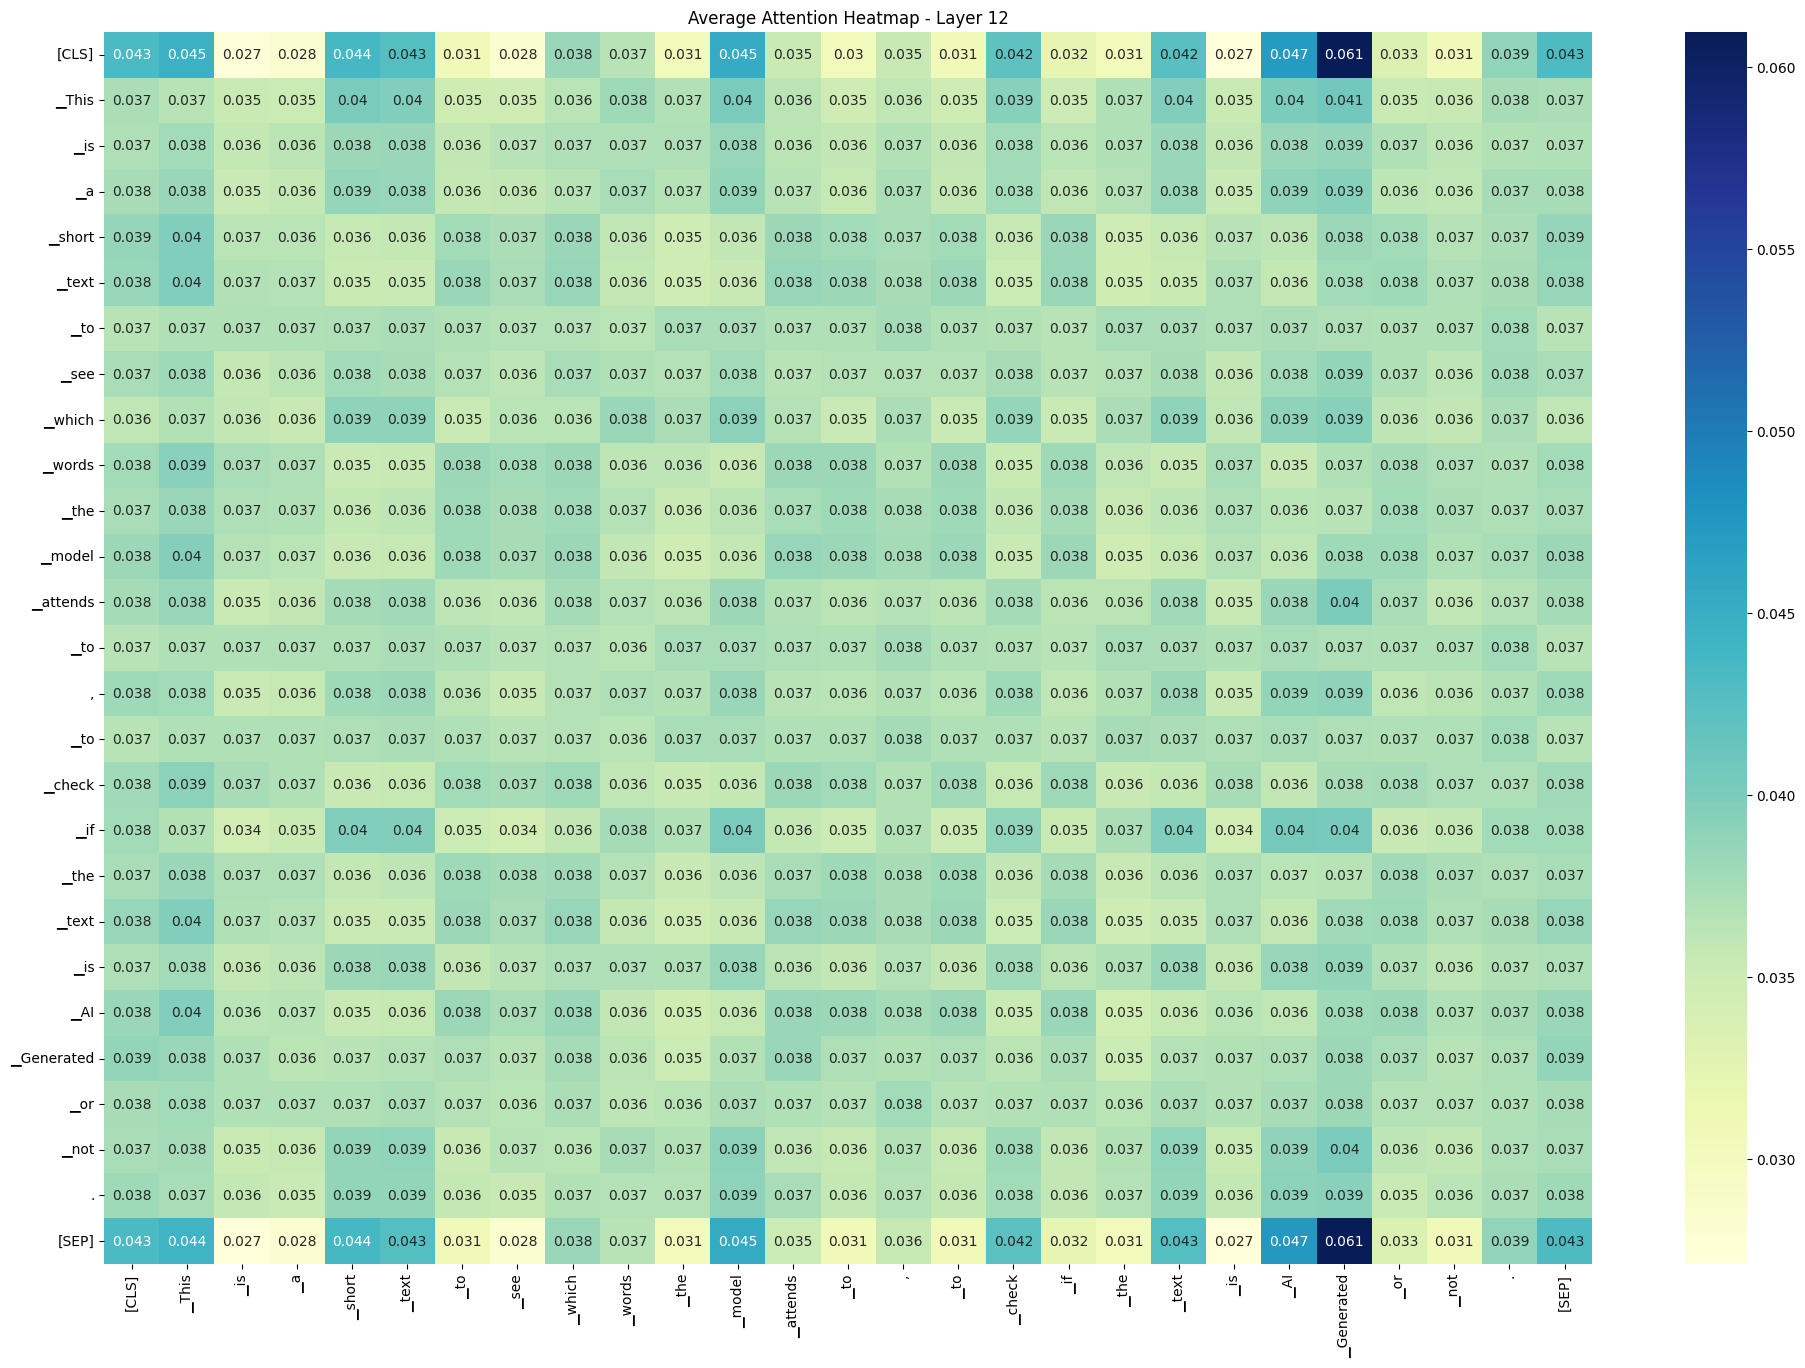

In [101]:
import seaborn as sns

# Calculate the average attention across all heads
layer_num = 11
average_attention_weights = torch.mean(attentions[layer_num], dim=1).cpu().squeeze(0).detach().numpy()

# Filter out [PAD] tokens and corresponding attention weights
non_pad_tokens = [token for token in input_data.tokens() if token != '[PAD]']
non_pad_attention_weights = np.array([avg_attention[:len(non_pad_tokens)] for avg_attention in average_attention_weights[:len(non_pad_tokens)]])

# Plot the attention heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(non_pad_attention_weights, annot=True, cmap="YlGnBu", xticklabels=non_pad_tokens, yticklabels=non_pad_tokens)
plt.title("Average Attention Heatmap - Layer {}".format(layer_num + 1))
plt.show()


In [102]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier on the training data
nb_classifier.fit(tfidf_matrix_train,train_set.label)

MultinomialNB()

In [103]:
from sklearn.metrics import classification_report
ypred = nb_classifier.predict(tfidf_matrix_test)
# Evaluate the accuracy
print(classification_report(test_set.label, ypred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1769
           1       0.95      0.95      0.95      2768

    accuracy                           0.94      4537
   macro avg       0.94      0.94      0.94      4537
weighted avg       0.94      0.94      0.94      4537



0.9854245565078732


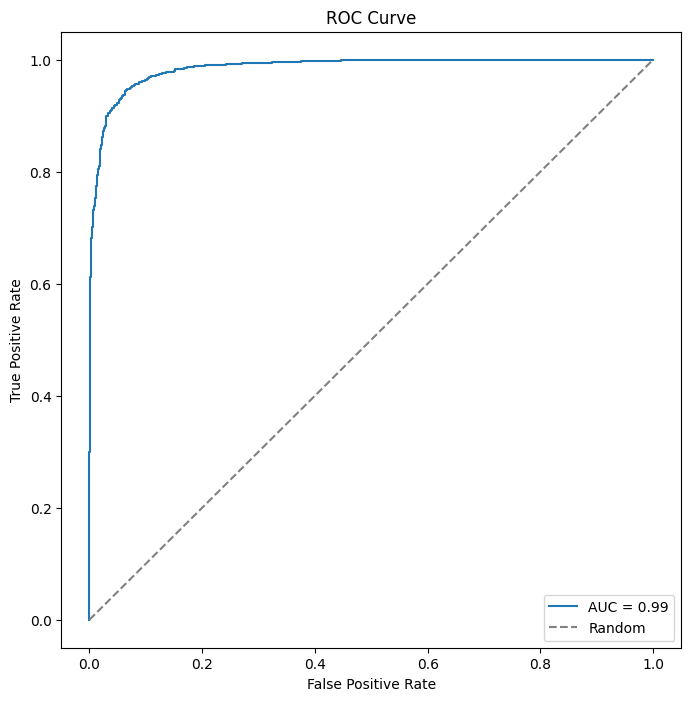

In [104]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
ypred =nb_classifier.predict_proba(tfidf_matrix_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_set.label,nb_classifier.predict_proba(tfidf_matrix_test)[:, 1])

# Calculate the AUC-ROC score
auc_score = roc_auc_score(test_set.label, ypred)
print(auc_score)
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [118]:
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming tfidf_matrix_train, tfidf_matrix_val, tfidf_matrix_test are your TF-IDF matrices
X_train_tensor = torch.Tensor(tfidf_matrix_train.toarray()).to(device)
y_train_tensor = torch.LongTensor(train_set.label.values).to(device)

X_val_tensor = torch.Tensor(tfidf_matrix_val.toarray()).to(device)
y_val_tensor = torch.LongTensor(val_set.label.values).to(device)

X_test_tensor = torch.Tensor(tfidf_matrix_test.toarray()).to(device)
y_test_tensor = torch.LongTensor(test_set.label.values).to(device)

# Create DataLoader for training, validation, and testing sets
train_dataset_NN = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_NN = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_NN = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader_NN = DataLoader(train_dataset_NN, batch_size=batch_size, shuffle=True)
val_loader_NN = DataLoader(val_dataset_NN, batch_size=batch_size, shuffle=False)
test_loader_NN = DataLoader(test_dataset_NN, batch_size=batch_size, shuffle=False)


In [119]:
class NNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

In [120]:
input_size = tfidf_matrix_train.shape[1]  
hidden_size = 128 
output_size = 2
modelNN = NNModel(input_size, hidden_size, output_size).to(device)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(modelNN.parameters(), lr=0.001)

# Train model
num_epochs = 10

for epoch in range(num_epochs):
    modelNN.train()
    for inputs, labels in train_loader_NN:
        optimizer.zero_grad()
        outputs = modelNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on the validation set
    modelNN.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader_NN:
            outputs = modelNN(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}')


Epoch 1/10, Loss: 0.0162, Validation Accuracy: 0.9833
Epoch 2/10, Loss: 0.0049, Validation Accuracy: 0.9850
Epoch 3/10, Loss: 0.0007, Validation Accuracy: 0.9859
Epoch 4/10, Loss: 0.0052, Validation Accuracy: 0.9859
Epoch 5/10, Loss: 0.0002, Validation Accuracy: 0.9844
Epoch 6/10, Loss: 0.0011, Validation Accuracy: 0.9848
Epoch 7/10, Loss: 0.0002, Validation Accuracy: 0.9839
Epoch 8/10, Loss: 0.0005, Validation Accuracy: 0.9839
Epoch 9/10, Loss: 0.0012, Validation Accuracy: 0.9819
Epoch 10/10, Loss: 0.0002, Validation Accuracy: 0.9844


In [122]:
# Evaluate on the test set
modelNN.eval()
ypred=[]
y_prob = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader_NN:
        outputs = modelNN(inputs)
        pred_val, predicted = torch.max(outputs.data, 1)
        y_prob.append(outputs.data)
        ypred.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9857


In [123]:
ypred_flat = torch.cat(ypred, dim=0).cpu()
y_prob_flat = torch.cat(y_prob, dim=0).cpu()
y_test_tensor = y_test_tensor.cpu()

In [124]:
from sklearn.metrics import classification_report
# Evaluate the accuracy
print(classification_report(y_test_tensor, ypred_flat))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1769
           1       0.99      0.99      0.99      2768

    accuracy                           0.99      4537
   macro avg       0.98      0.99      0.98      4537
weighted avg       0.99      0.99      0.99      4537



0.9984901743906782


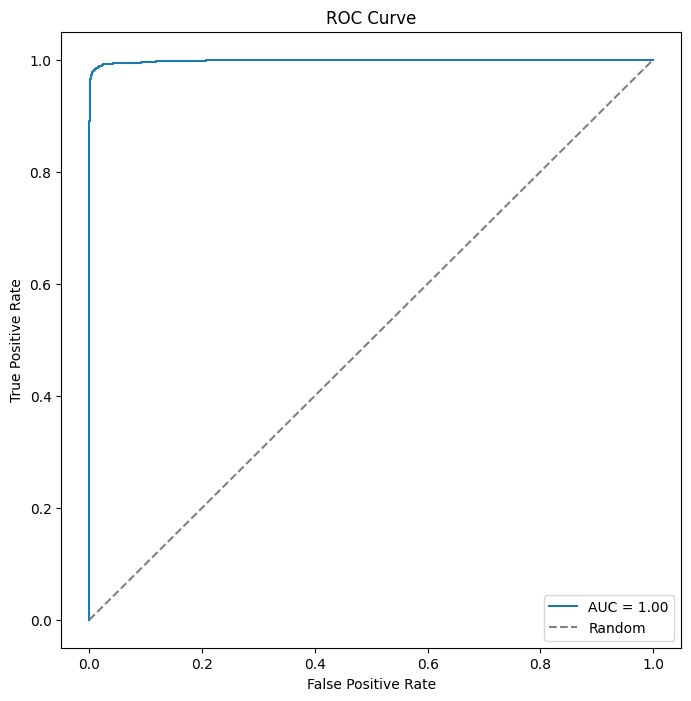

In [125]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_tensor,y_prob_flat[:, 1])

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test_tensor, y_prob_flat[:, 1])
print(auc_score)
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [142]:
text = ['''
Nearly all Tetris games allow the player to press a button to increase the speed of the current piece's descent or cause the piece to drop and lock into place immediately, known as a "soft drop" and a "hard drop", respectively. While performing a soft drop, the player can also stop the piece's increased speed by releasing the button before the piece settles into place. Some games allow only one of either soft drop or hard drop; others have separate buttons for each. Many games award a number of points based on the height that the piece fell before locking, so using the hard drop generally awards more points.
''']

In [143]:
def predictNN(text):
    inputt = tfidf_vectorizer.transform(text)
    inputt = torch.Tensor(inputt.toarray()).to(device)
    return model(inputt)

In [144]:
def predictNB(text):
    inputt = tfidf_vectorizer.transform(text)
    inputt = torch.Tensor(inputt.toarray())
    return nb_classifier.predict(inputt)

In [148]:
print(predictNN(text_human))
print(predictNN(text_GPT))
print(predictNN(text_short))
print(predictNN(text))


print(predictNB(text_human))
print(predictNB(text_GPT))
print(predictNB(text_short))
print(predictNB(text))


tensor([[-2.0298,  1.9071]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.3126,  2.2059]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.4972, -1.0832]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.9919,  0.6760]], device='cuda:0', grad_fn=<AddmmBackward0>)
[0]
[0]
[0]
[0]


In [129]:
predictNB(text_human)

array([0])